<a href="https://colab.research.google.com/github/Ankur2227/CV/blob/main/SigModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dataset = pd.read_csv('/content/drive/MyDrive/sign_data/train_data.csv', header = None)
test_dataset = pd.read_csv('/content/drive/MyDrive/sign_data/test_data.csv', header = None)
train_dir = "/content/drive/MyDrive/sign_data/train"
test_dir = "/content/drive/MyDrive/sign_data/test"

In [3]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir

    def shuffle(self):
        return self.dataset.sample(frac=1)

    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8)

        img_cv2 = cv2.Canny(img.numpy(), 20, 220)

        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0

        return img_cv2

    def datagen(self):
        num_samples = len(self.dataset)
        while True:

            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):

                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label

In [4]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)

# Create train, val and test
train_gen = DataLoader(train_set, 256, train_dir)
val_gen = DataLoader(val_set, 256, train_dir)
test_gen = DataLoader(test_dataset, 256, test_dir)

Pair 1:
Label: 0


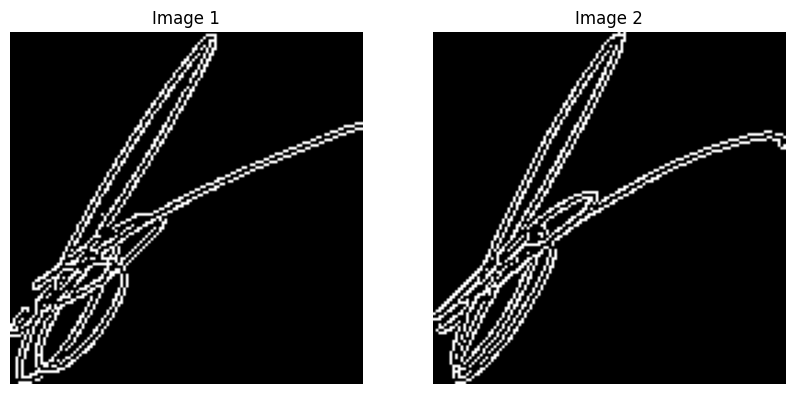

Pair 2:
Label: 0


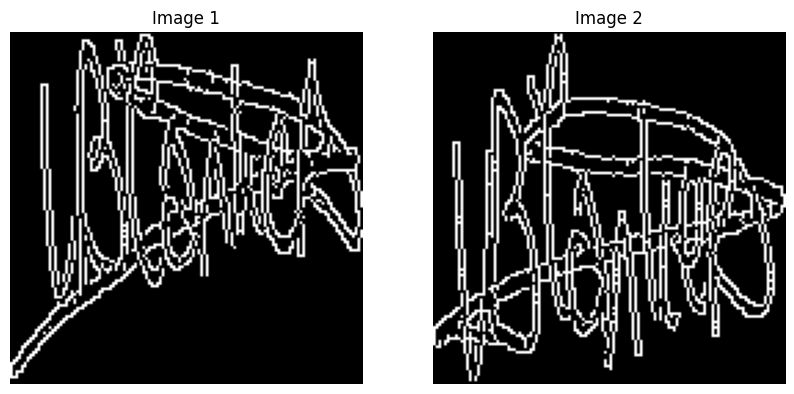

Pair 3:
Label: 0


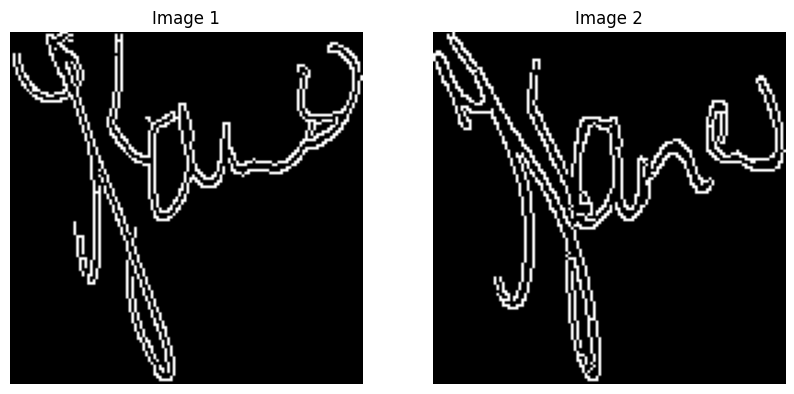

Pair 4:
Label: 0


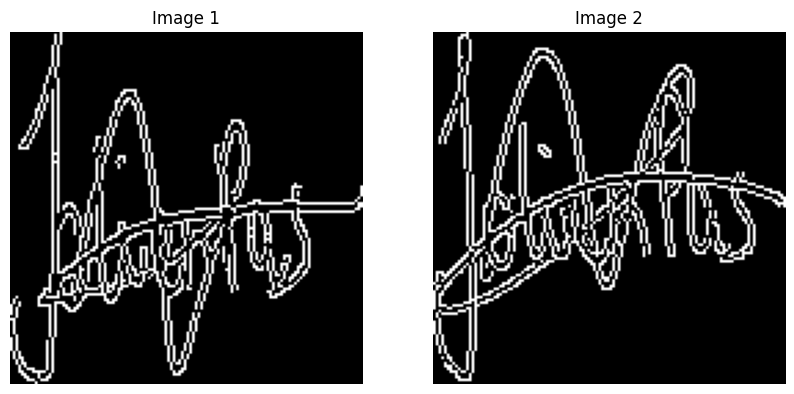

Pair 5:
Label: 0


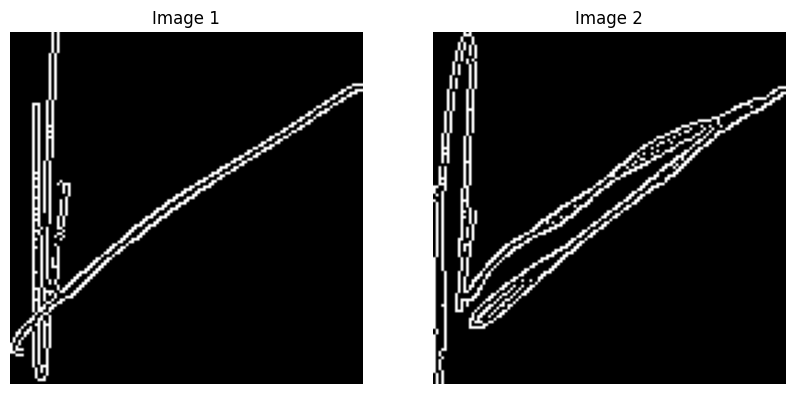

In [5]:
# Create data generator
generator = train_gen.datagen()

# Plot 5 1st images in batch
for i in range(5):
    batch_data, label = next(generator)

    pair_data = batch_data["image1"], batch_data["image2"]

    print(f"Pair {i+1}:")
    print("Label:", label[0])

    plt.figure(figsize=(10, 5))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(pair_data[j][0], cmap='gray')
        plt.title('Image {}'.format(j+1))
        plt.axis('off')

    plt.show()

In [6]:
input_shape = (128, 128, 1)

In [7]:
def create_siamese_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))

    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)

    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])


    output = Dense(1, activation='sigmoid')(manhattan_distance)

    return Model(inputs=[input1, input2], outputs=output)

In [8]:
model = create_siamese_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer)       │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image2 (InputLayer)       │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │      2,522,624 │ image1[0][0],          │
│                           │                        │                │ image2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            129 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,522,753 (9.62 MB)

 Trainable params: 2,522,753 (9.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.kernel.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]


In [10]:
# Model training
history = model.fit(x=train_gen.datagen(),
                            steps_per_epoch=len(train_set) // 256,
                            epochs=8,
                            validation_data=val_gen.datagen(),
                            validation_steps=len(val_set) // 256,
                            callbacks=callbacks_list)

Epoch 1/8
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6035 - loss: 0.6583
Epoch 1: val_accuracy improved from -inf to 0.64222, saving model to best_model.kernel.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 646s 10s/step - accuracy: 0.6042 - loss: 0.6578 - val_accuracy: 0.6422 - val_loss: 0.6050
Epoch 2/8
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7264 - loss: 0.5456
Epoch 2: val_accuracy improved from 0.64222 to 0.81771, saving model to best_model.kernel.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 572s 9s/step - accuracy: 0.7267 - loss: 0.5451 - val_accuracy: 0.8177 - val_loss: 0.4470
Epoch 3/8
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8256 - loss: 0.3909
Epoch 3: val_accuracy improved from 0.81771 to 0.90155, saving model to best_model.kernel.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 573s 8s/step - accuracy: 0.8259 - loss: 0.3904 - val_accuracy: 0.9016 - val_loss: 0.2807
Epoch 4/8
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8954 - loss: 0.2563
Epoch 4: val_accuracy improved from 0.

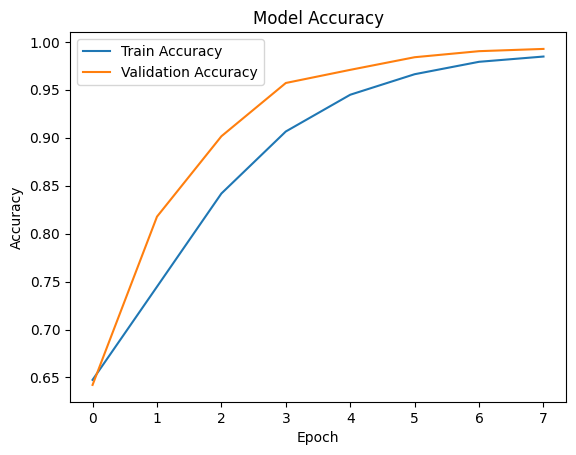

In [11]:
# Train and val model accuracy per epoch
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [13]:
# load weights
model.load_weights("best_model.kernel.keras")

/content/drive/MyDrive/sign_data/test_data.csv

In [15]:
mytest_dir = "sign_data/my_test"
mytest_dataset = pd.read_csv('/content/drive/MyDrive/sign_data/test_data.csv', header = None)

In [16]:
# Testing model on test dataset
test_loss, test_accuracy = model.evaluate(test_gen.datagen(),
                                          steps=len(test_dataset) // 256)

22/22 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.9991 - loss: 0.0090


In [17]:
# Getting image pairs and their labels for the test dataset
test_pairs, test_labels = next(test_gen.datagen())

In [18]:
# Getting predictions for the test dataset
test_predictions = model.predict(test_pairs)

# Conversion of predictions to binary format (0 or 1)
binary_predictions = (test_predictions > 0.5).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Pair 67
True Label: 1
Predicted Label: [1]


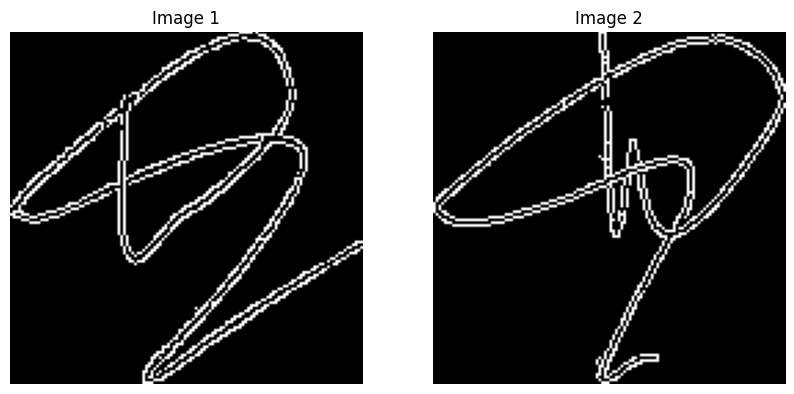

Pair 225
True Label: 1
Predicted Label: [1]


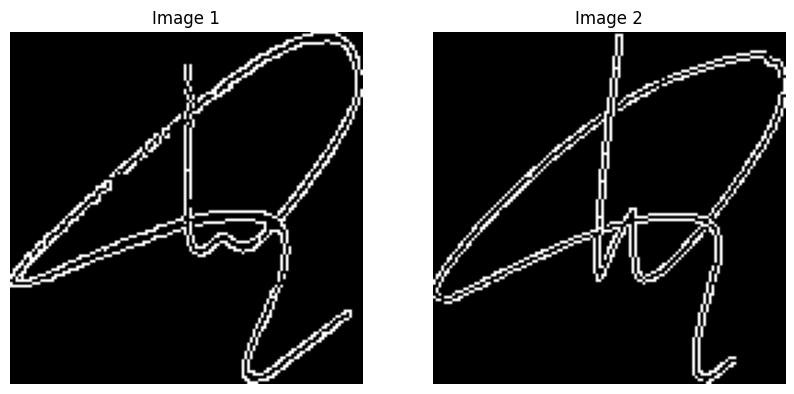

Pair 97
True Label: 1
Predicted Label: [1]


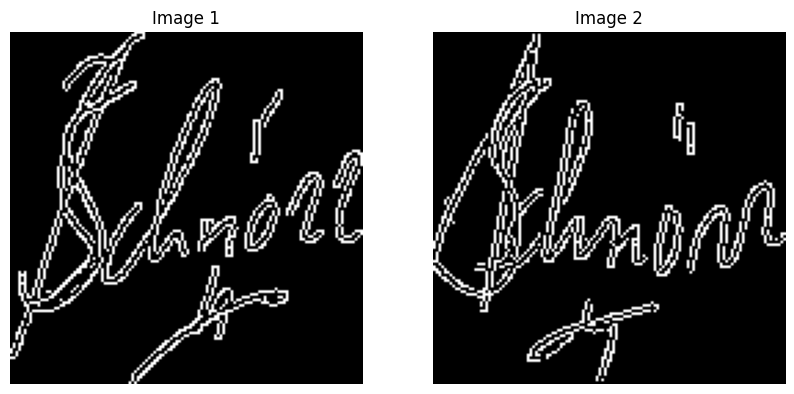

Pair 29
True Label: 0
Predicted Label: [0]


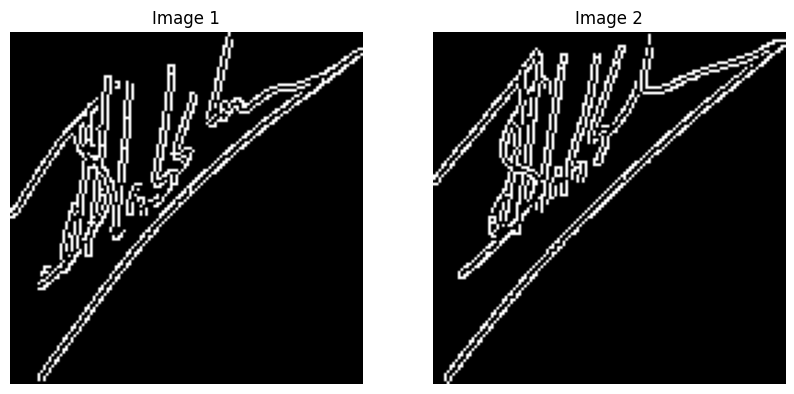

Pair 171
True Label: 0
Predicted Label: [0]


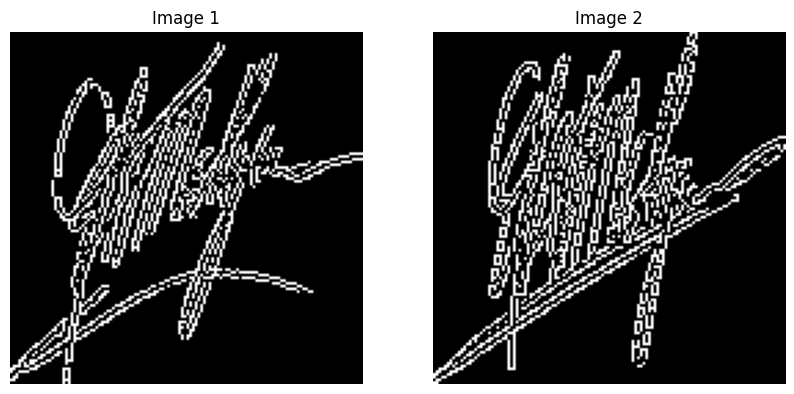

Pair 113
True Label: 0
Predicted Label: [0]


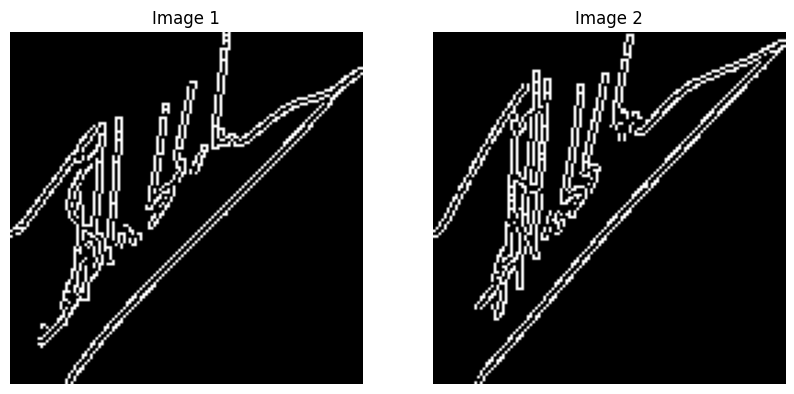

Pair 182
True Label: 0
Predicted Label: [0]


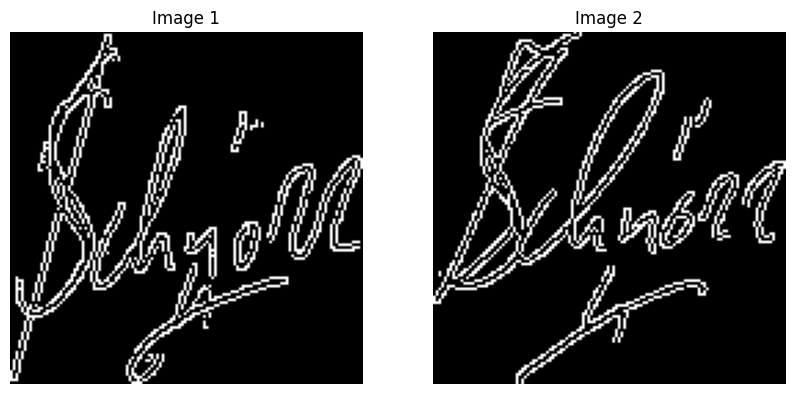

Pair 231
True Label: 1
Predicted Label: [1]


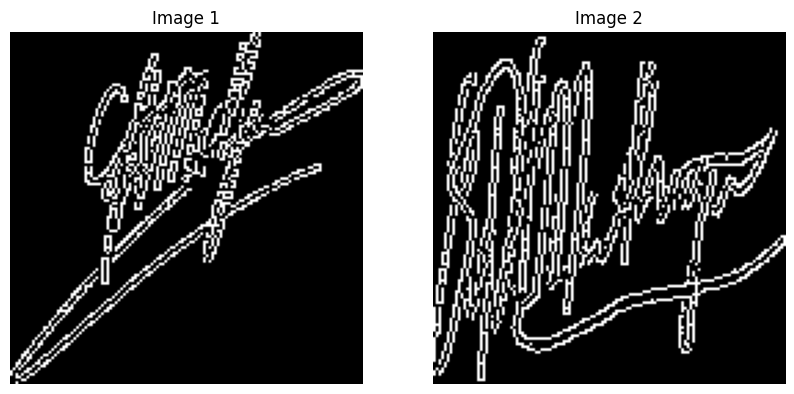

Pair 235
True Label: 0
Predicted Label: [0]


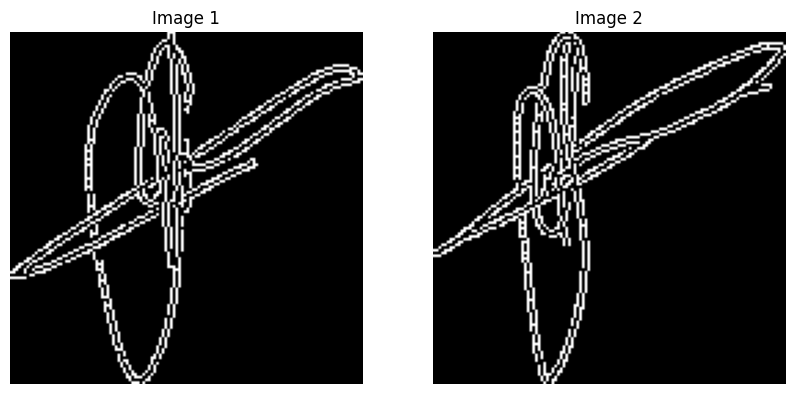

Pair 71
True Label: 0
Predicted Label: [0]


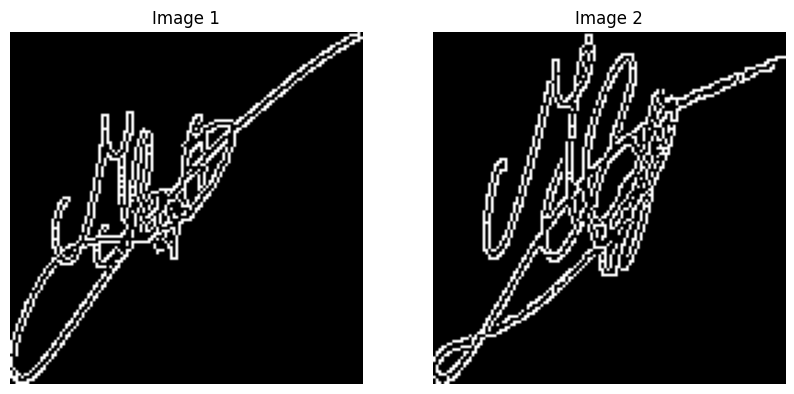

Pair 75
True Label: 1
Predicted Label: [1]


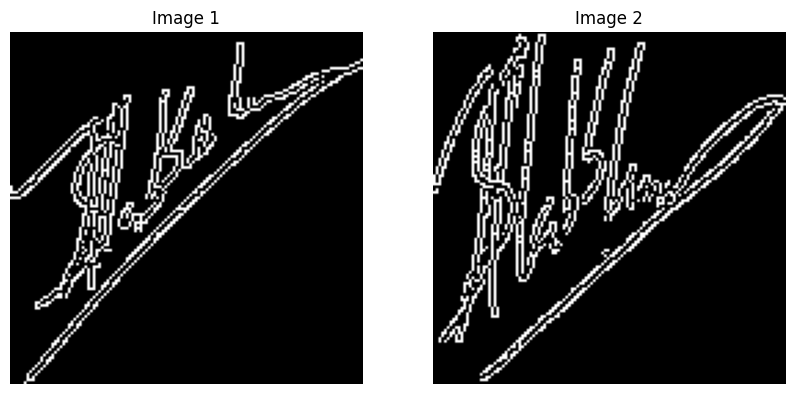

Pair 156
True Label: 1
Predicted Label: [1]


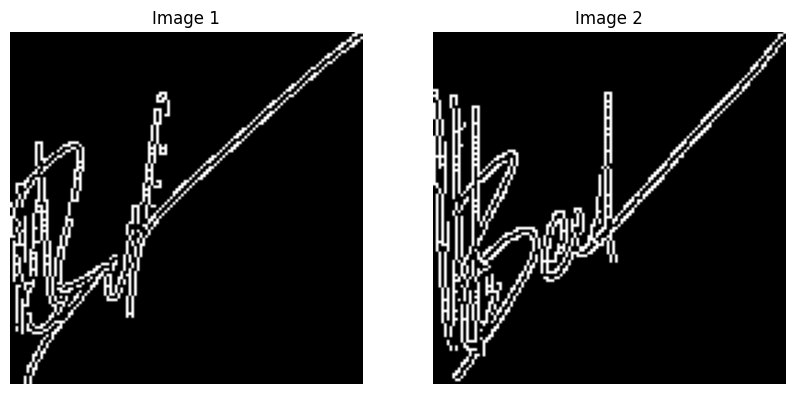

Pair 236
True Label: 0
Predicted Label: [0]


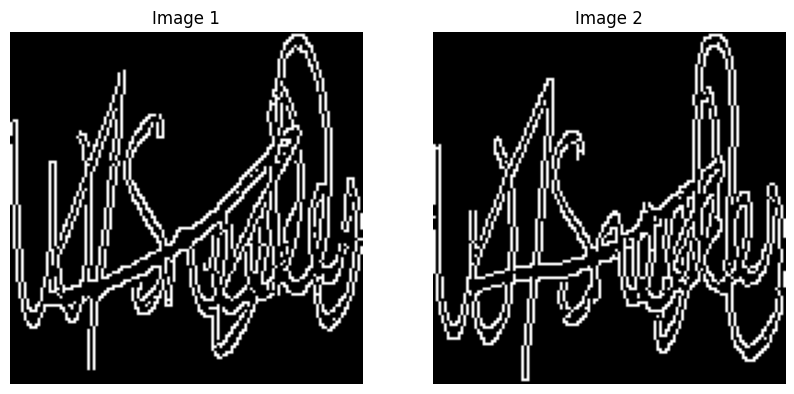

Pair 201
True Label: 0
Predicted Label: [0]


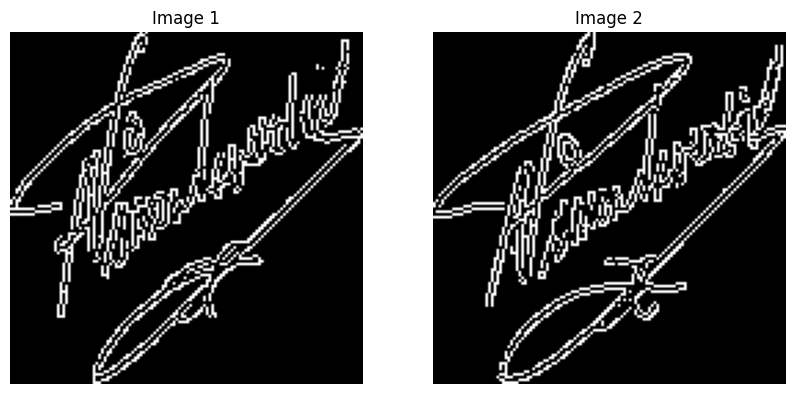

Pair 26
True Label: 1
Predicted Label: [1]


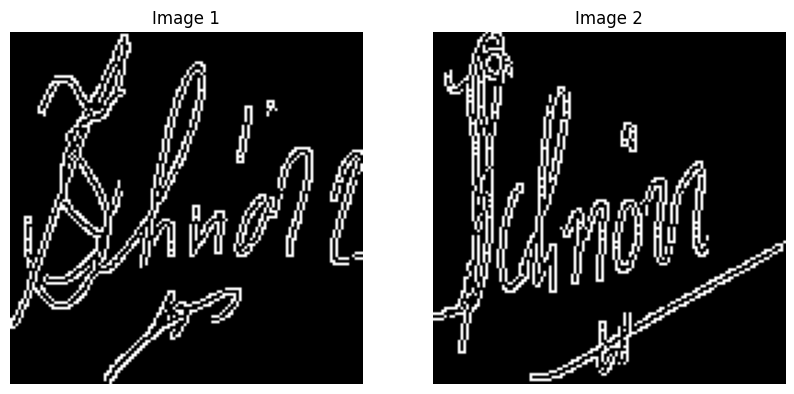

Pair 202
True Label: 0
Predicted Label: [0]


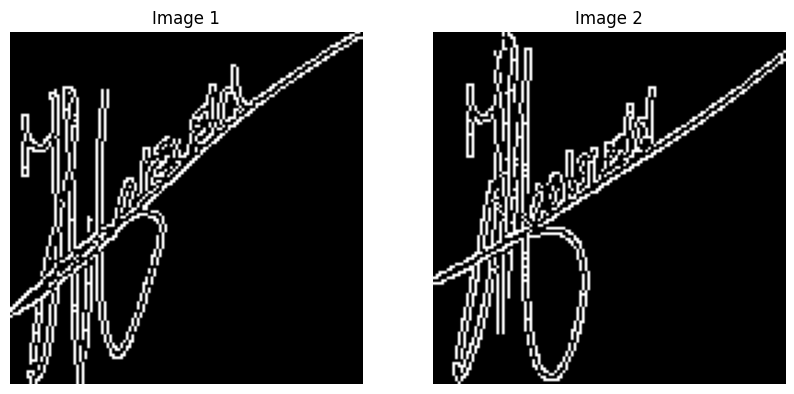

Pair 37
True Label: 0
Predicted Label: [0]


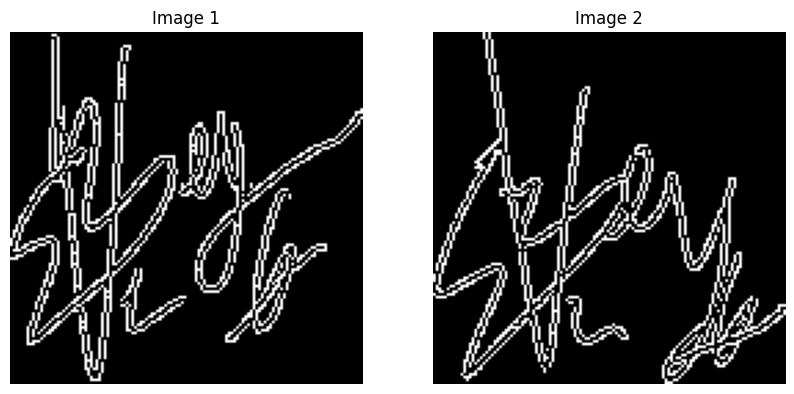

Pair 162
True Label: 1
Predicted Label: [1]


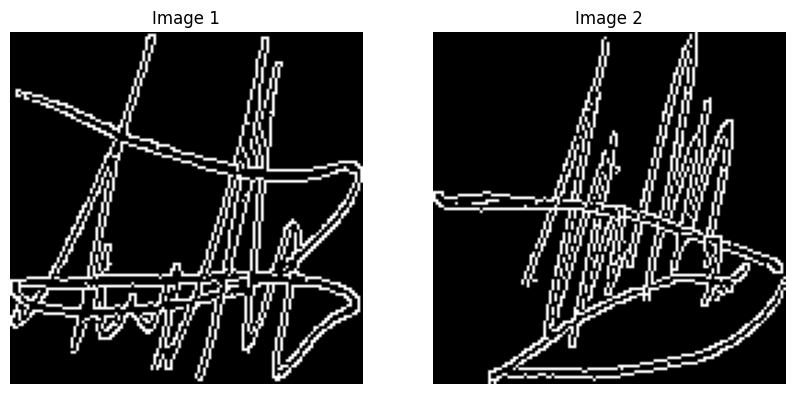

Pair 204
True Label: 0
Predicted Label: [0]


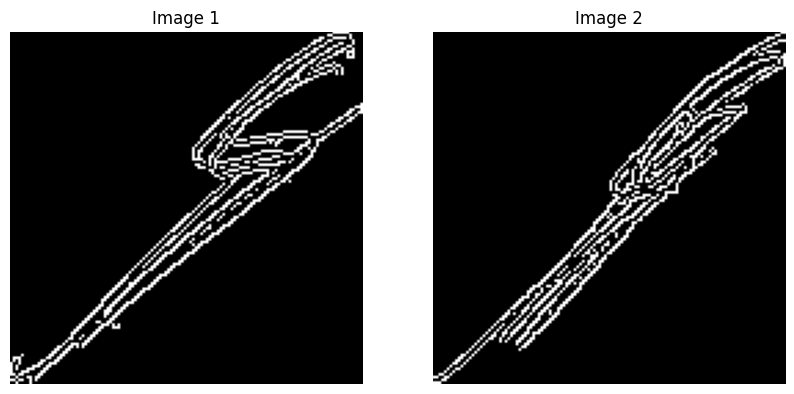

Pair 241
True Label: 0
Predicted Label: [0]


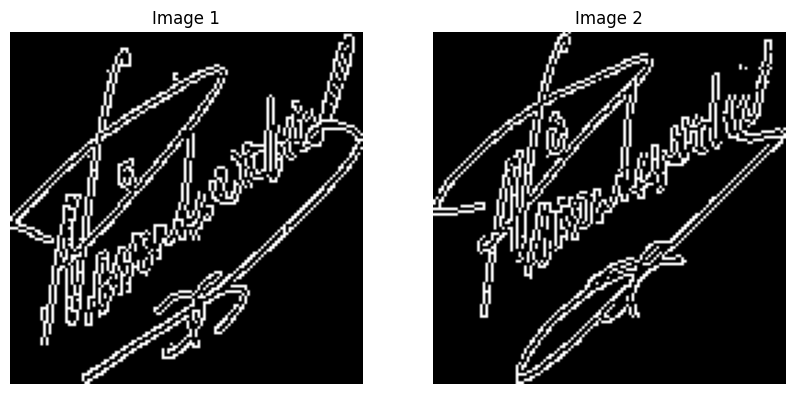

In [19]:
import random

# Getting random 20 pair indices for output
random_indices = random.sample(range(len(test_pairs['image1'])), 20)

# Output random 20 pairs of images, their true labels and predicted labels
for i in random_indices:
    # Получение изображений
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]

    # Getting the true label and predicted label
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]

    # output
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)

    # Отображение изображений
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')

    plt.show()